# Model Processing

## Imports & General Settings 

In [1]:
import unittest
import os
import sys
import time
import pathlib

import matplotlib.pyplot as plt
import sklearn
import pandas as pd
import numpy as np
import torch
import torch.nn.functional as F
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import ToPILImage
import PIL
from tqdm.notebook import trange, tqdm
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, average_precision_score, roc_curve, roc_auc_score
from matplotlib import pyplot
from scipy.signal import resample


# Our imports
from data import WaveletTransform, AFECGDataset, SecondDataset, WrapperDataset
import dsp
from model.blocks import ConvNet, BRNN, SoftmaxAttention
from model.baseline import Baseline
from training import train, test
import utils


%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
testCase = unittest.TestCase()
plt.rcParams.update({'font.size': 12})
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cpu


## Dataset creation

In [3]:
dataset_name = 'afdb'
dataset = SecondDataset(dataset_name, '../data/afdb/', wt=WaveletTransform(resample=20))

In [4]:
# dataset.load(num_records=1)
dataset.load('./temp/' + dataset_name)

Loaded 28104 samples from backup
torch.Size([28104])
torch.Size([28104, 92, 375])


In [5]:
images_per_sample = 20
total_data_size = len(dataset)
print("Total data size: ", total_data_size)
print("Samples with AF: ", dataset.labels.sum().item())

Total data size:  28104
Samples with AF:  552


##  Wavelet Transform

Has AF:  Yes


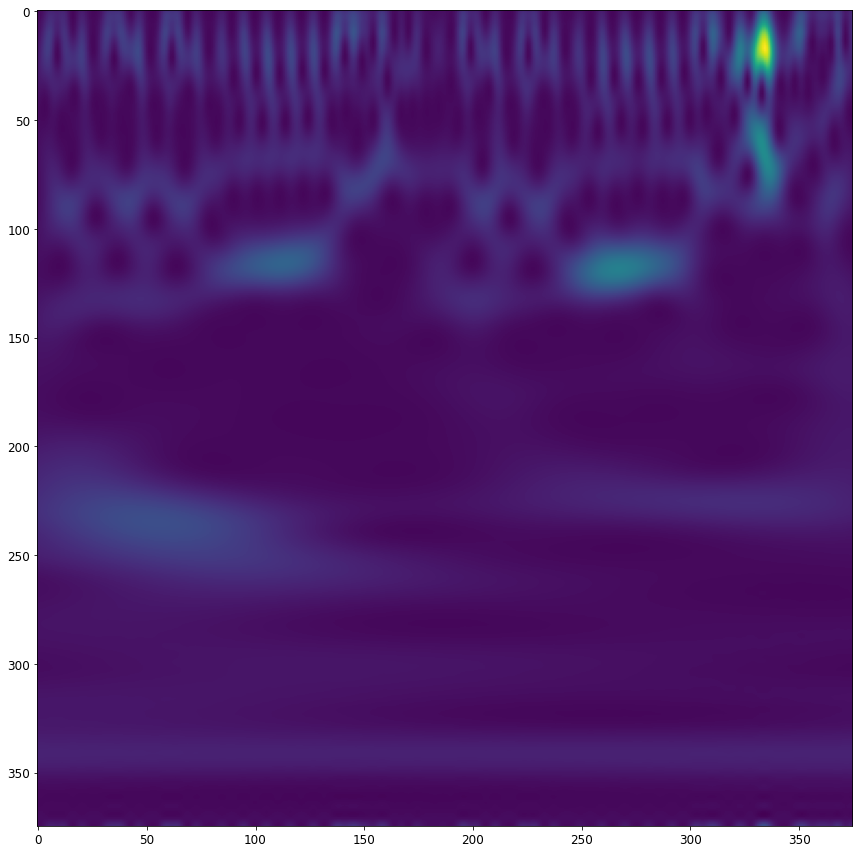

In [6]:
power, label = dataset[0]
print('Has AF: ', 'Yes' if label == 1 else 'No')

signal = resample(power, 375)
plt.figure(figsize=(15, 15))
plt.imshow(signal)
plt.show()

Has AF:  No


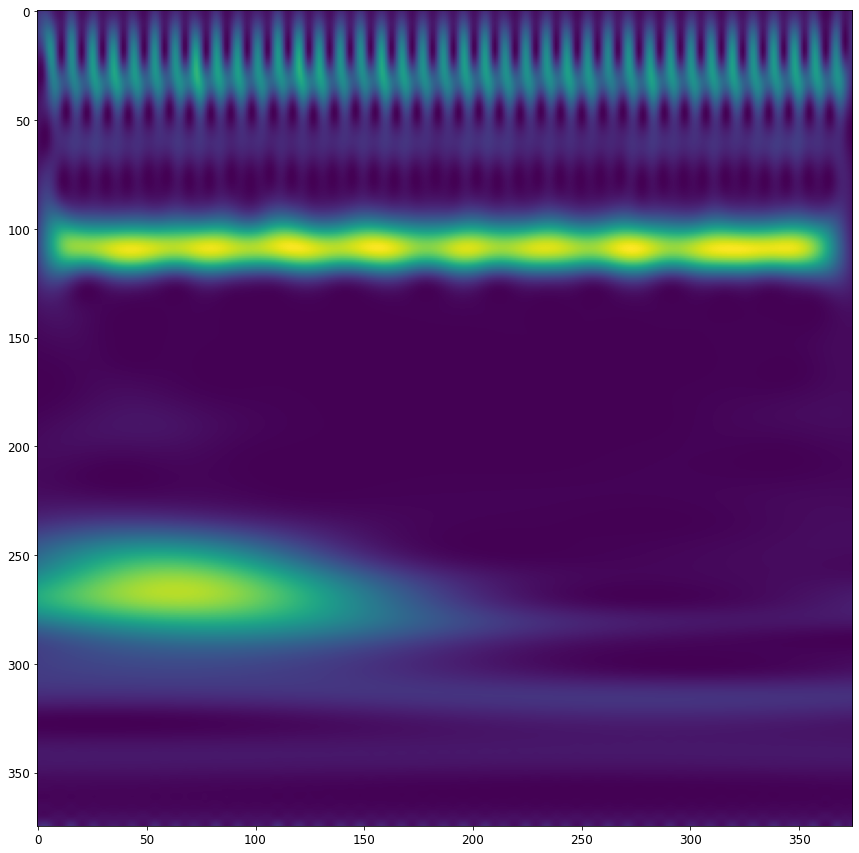

In [7]:
power, label = dataset[59]
print('Has AF: ', 'Yes' if label == 1 else 'No')

signal = resample(power, 375)
plt.figure(figsize=(15, 15))
plt.imshow(signal)
plt.show()

## Training

In [8]:
# heldout = int(len(dataset) * 0.2)
# train_dataset, test_dataset = torch.utils.data.random_split(dataset, [len(dataset) - heldout, heldout])
# train_indices = train_dataset.indices
# test_indices = test_dataset.indices
# print('[Train] Positive cases = {}'.format((dataset.labels[train_indices] == 1).sum()))
# print('[Test] Positive cases = {}'.format((dataset.labels[test_indices] == 1).sum()))

In [9]:
# true_idx = [i for i, x in enumerate(dataset.labels == 1) if x == True]
# train_idx = true_idx + list(np.arange(0,437))
# train_dataset = torch.utils.data.Subset(dataset, list(set(train_idx)))

In [10]:
true_idx = [i for i, x in enumerate(dataset.labels == 1) if x == True]
false_idx = [i for i, x in enumerate(dataset.labels == 0) if x == True]
print("True idx total, False idx total: ", len(true_idx), len(false_idx))

idxes = true_idx + false_idx[0:len(true_idx)]
print(len(idxes))

True idx total, False idx total:  552 27552
1104


In [11]:
dataset = torch.utils.data.Subset(dataset, list(set(idxes)))

In [12]:
heldout = int(len(dataset) * 0.2)
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [len(dataset) - heldout, heldout])
train_indices = train_dataset.indices
test_indices = test_dataset.indices
# print('[Train] Positive cases = {}'.format((dataset.labels[train_indices] == 1).sum()))
# print('[Test] Positive cases = {}'.format((dataset.labels[test_indices] == 1).sum()))

### Baseline

In [ ]:
model = nn.Sequential(
    ConvNet((30, 375), batch=False),
    nn.Linear(50, 2)
)

config = dict(
    num_workers=2,
    batch_size=30,
    learning_rate=0.001,
    weight_decay=0.01,
    num_epochs=20,
    is_notebook=True
)

train(model, train_dataset, config, device=device)

Ground truth: tensor([0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0,
        0, 1, 1, 1, 1, 0])
Prediction: tensor([0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0,
        0, 0, 0, 1, 0, 0])
Ground truth: tensor([1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0,
        0, 0, 0, 1, 0, 0])
Prediction: tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0])
Ground truth: tensor([0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1,
        0, 0, 1, 1, 0, 0])
Prediction: tensor([1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0,
        1, 1, 0, 0, 1, 1])
Ground truth: tensor([1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0,
        0, 1, 1, 0, 0, 1])
Prediction: tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 1])
Ground truth: tensor([1, 0, 1, 1, 0, 1, 

Ground truth: tensor([1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0,
        1, 0, 1, 1, 0, 0])
Prediction: tensor([1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0,
        1, 0, 1, 1, 0, 0])
Ground truth: tensor([0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0,
        0, 0, 1, 1, 1, 0])
Prediction: tensor([0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0,
        0, 0, 1, 1, 1, 0])
Ground truth: tensor([0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1,
        1, 1, 0, 0, 1, 1])
Prediction: tensor([0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1,
        1, 1, 0, 0, 0, 1])
Ground truth: tensor([1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0,
        0, 0, 1, 1, 0, 0])
Prediction: tensor([1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0,
        0, 0, 1, 1, 0, 0])
Ground truth: tensor([1, 0, 0, 0, 1, 1, 

Ground truth: tensor([0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0,
        0, 0, 0, 1, 1, 1])
Prediction: tensor([0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0,
        0, 0, 0, 1, 1, 1])
Ground truth: tensor([0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1,
        1, 1, 1, 0, 0, 1])
Prediction: tensor([0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1,
        0, 1, 1, 0, 0, 1])
Ground truth: tensor([1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1,
        1, 0, 0, 1, 0, 1])
Prediction: tensor([1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1,
        1, 0, 1, 1, 0, 1])
Ground truth: tensor([1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0,
        0, 1, 0, 0, 0, 0])
Prediction: tensor([1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0,
        0, 1, 0, 0, 0, 0])
Ground truth: tensor([0, 0, 1, 0, 0, 0, 

Ground truth: tensor([0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1,
        1, 1, 1, 1, 0, 1])
Prediction: tensor([0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1,
        1, 1, 1, 1, 0, 1])
Ground truth: tensor([1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0,
        1, 1, 0, 0, 0, 0])
Prediction: tensor([1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0,
        1, 1, 0, 0, 0, 0])
Ground truth: tensor([1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1,
        1, 0, 0, 1, 1, 1])
Prediction: tensor([1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1,
        1, 0, 0, 1, 1, 1])
Ground truth: tensor([0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1,
        0, 0, 1, 0, 1, 1])
Prediction: tensor([0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1,
        0, 0, 1, 0, 1, 1])
Ground truth: tensor([1, 0, 1, 1, 0, 1, 

## Testing

In [ ]:
# y_true = dataset.labels[test_dataset.indices]
y_pred, test_acc = test(model, test_dataset, config)

In [ ]:
y_true = [y for x, y in test_dataset]
len(y_true)

In [ ]:
from sklearn import metrics
results = pd.DataFrame(classification_report(y_true, y_pred, zero_division=0, output_dict=True)).transpose()
tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
specificity = tn / (tn+fp)
fpr, tpr, thresholds = metrics.roc_curve(y_true, y_pred)
auc_score = metrics.auc(fpr, tpr)

In [ ]:
display(results)
print("Specificity:", specificity)
print("AUC:", auc_score)

In [ ]:
lr_auc = roc_auc_score(y_true, y_pred)
print('ROC AUC=%.3f' % (lr_auc))
lr_fpr, lr_tpr, _ = roc_curve(y_true, y_pred)
pyplot.plot(lr_fpr, lr_tpr, marker='.', label='Baseline model')

pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
pyplot.legend()
pyplot.show()

In [ ]:
pr_auc = average_precision_score(y_true, y_pred)
print("PR AUC:", specificity)